In [4]:
import torch
from math import log
from collections import OrderedDict
from itertools import product
import os
from IPython.display import clear_output
from matplotlib import pyplot as plt

In [134]:
D = 4
H = 15
R0 = 0.1
op = 100000
batch = 10
hidden_size = 70
lr_TB = 0.001
lr_TBpb = 0.001
lr_DB = 0.001
lr_Z = 0.01

In [135]:
def transfer(state):
    global H, D, batch
    res = [[float(0)] * H * D for i in range(batch)]
    for k in range(0, batch):
        for i in range(0, D):
            res[k][state[k][i] + i * H] = float(1)
    return res

In [136]:
def reward(x):
    global R0, D, H
    f1 = True
    f2 = True
    for d in range(D):
        if not (0.25 < abs(x[d] / (H - 1) - 0.5) <= 0.5): f1 = False
        if not (0.3 < abs(x[d] / (H - 1) - 0.5) < 0.4): f2 = False
    return (R0 + 0.5 * f1 + 2 * f2)

In [137]:
rewards = torch.zeros(*[H for i in range(D)])
coord_diap = [range(H) for _ in range(D)]

for coord in product(*coord_diap):
    rewards[tuple(coord)] = reward(torch.tensor(coord))

rewards /= rewards.sum()

def eloss(a, samples=1000):
    counter = torch.zeros(*[H for i in range(D)])
    for i in range(samples):
        counter[tuple(a[i])] += 1

    counter /= counter.sum()

    return (rewards - counter).abs().sum()

In [138]:
model_DB = torch.nn.Sequential(
    OrderedDict([
        ("linear_1", torch.nn.Linear(D * H, hidden_size)),
        ("activation_1", torch.nn.ReLU()),
        ("linear_2", torch.nn.Linear(hidden_size, D + 2))
    ])
)
optimizer_DB = torch.optim.Adam(
    model_DB.parameters(),
    lr=lr_DB
)

In [139]:
def loss_fn_DB():
    global H, D, batch
    used = [0] * batch
    states = [[0] * D for i in range(batch)]
    ways = [[] for i in range(batch)]
    m = torch.nn.Softmax(dim=1)    
    while True:
        if torch.tensor(used).min() == 1:
            break
        pred = model_DB(torch.tensor(transfer(states)))
        p_Fs = pred[:, 0: -1]
        Fs = pred[:, -1]
        for j in range(0, batch):
            if used[j]:
                continue
            for i in range(0, D):
                if states[j][i] == H - 1:
                    p_Fs[j][i] = -float("inf")
        p_Fs = m(p_Fs)
        ind = torch.distributions.categorical.Categorical(p_Fs).sample()
        for j in range(0, batch):
            if used[j]:
                continue
            p_B = max(len([it for it in states[j] if it]), 1)
            ways[j].append([Fs[j], torch.log(p_Fs[j][ind[j]]), log(1 / p_B)])
            if ind[j] == D:
                ways[j].append([log(reward(states[j])), 0, 0])
                used[j] = True
            else:
                assert (states[j][ind[j]] != H - 1)
                states[j][ind[j]] += 1
    loss = 0
    for j in range(batch):
        for i in range(0, len(ways[j]) - 1):
            loss += (ways[j][i][0] + ways[j][i][1] - ways[j][i + 1][0] - ways[j][i + 1][2]) ** 2
    loss /= batch
    return loss, states

In [140]:
model_TB_Pfs = torch.nn.Sequential(
    OrderedDict([
        ("linear_1", torch.nn.Linear(D * H, hidden_size)),
        ("activation_1", torch.nn.ReLU()),
        ("linear_2", torch.nn.Linear(hidden_size, 2 * D + 1))
    ])
)
optimizer_TB_Pfs = torch.optim.Adam(
    model_TB_Pfs.parameters(),
    lr=lr_TB
)

model_TB_log_Z = torch.nn.Parameter(torch.tensor(0.0, requires_grad=True))
optimizer_TB_log_Z = torch.optim.Adam([model_TB_log_Z], lr_Z)

In [141]:
def loss_fn_TB():
    global H, D, model_TB_log_Z, batch
    used = [0] * batch
    allstate = [[0] * D for i in range(batch)]
    way = [[] for i in range(batch)]
    m = torch.nn.Softmax(dim=1)  
    while True:
        if torch.tensor(used).min() == 1:
            break
        pred = model_TB_Pfs(torch.tensor(transfer(allstate)))
        p_Fs = pred[:, 0:D+1]
        for j in range(0, batch):
            if used[j]:
                continue
            for i in range(0, D):
                if allstate[j][i] == H - 1:
                    p_Fs[j][i] = -float("inf")
        p_Fs = m(p_Fs)
        ind = torch.distributions.categorical.Categorical(p_Fs).sample()
        for j in range(0, batch):
            if used[j]:
                continue
            p_B = max(len([it for it in allstate[j] if it]), 1)
            way[j].append([torch.log(p_Fs[j][ind[j]]), log(1 / p_B)])
            if ind[j] == D:
                way[j].append([0, 0])
                used[j] = True
            else:
                assert(allstate[j][ind[j]] != H - 1)
                allstate[j][ind[j]] += 1
    j = 0
    loss = 0
    for state in allstate:
        cur = model_TB_log_Z - log(reward(state))
        for i in range(0, len(way[j]) - 1):
            cur += way[j][i][0] - way[j][i + 1][1]
        cur = cur ** 2
        loss += cur
        j += 1
    loss /= batch
    return loss, allstate

In [142]:
model_TBpb_Pfs = torch.nn.Sequential(
    OrderedDict([
        ("linear_1", torch.nn.Linear(D * H, hidden_size)),
        ("activation_1", torch.nn.ReLU()),
        ("linear_2", torch.nn.Linear(hidden_size, 2 * D + 1))
    ])
)
optimizer_TBpb_Pfs = torch.optim.Adam(
    model_TBpb_Pfs.parameters(),
    lr=lr_TBpb
)

model_TBpb_log_Z = torch.nn.Parameter(torch.tensor(0.0, requires_grad=True))
optimizer_TBpb_log_Z = torch.optim.Adam([model_TB_log_Z], lr_Z)

In [143]:
def loss_fn_TBpb():
    global H, D, model_TB_log_Z, batch
    used = [0] * batch
    pr = [0] * batch
    allstate = [[0] * D for i in range(batch)]
    way = [[] for i in range(batch)]
    m = torch.nn.Softmax(dim=1)  
    while True:
        if torch.tensor(used).min() == 1:
            break
        pred = model_TB_Pfs(torch.tensor(transfer(allstate)))
        p_Fs = pred[:, 0 : D + 1]
        p_Bs = pred[:, D + 1:]
        for j in range(0, batch):
            if used[j]:
                continue
            for i in range(0, D):
                if allstate[j][i] == H - 1:
                    p_Fs[j][i] = -float("inf")
                if allstate[j][i] == 0:
                    p_Bs[j][i] = -float("inf")
        p_Fs = m(p_Fs)
        p_Bs = m(p_Bs)
        ind = torch.distributions.categorical.Categorical(p_Fs).sample()
        for j in range(0, batch):
            if used[j]:
                continue
            way[j].append([torch.log(p_Fs[j][ind[j]]), torch.log(p_Bs[j][pr[j]])])
            if ind[j] == D:
                way[j].append([0, 0])
                used[j] = True
            else:
                assert(allstate[j][ind[j]] != H - 1)
                allstate[j][ind[j]] += 1
                pr[j] = ind[j]
    j = 0
    loss = 0
    for state in allstate:
        cur = model_TB_log_Z - log(reward(state))
        for i in range(0, len(way[j]) - 1):
            cur += way[j][i][0] - way[j][i + 1][1]
        cur = cur ** 2
        loss += cur
        j += 1
    loss /= batch
    return loss, allstate

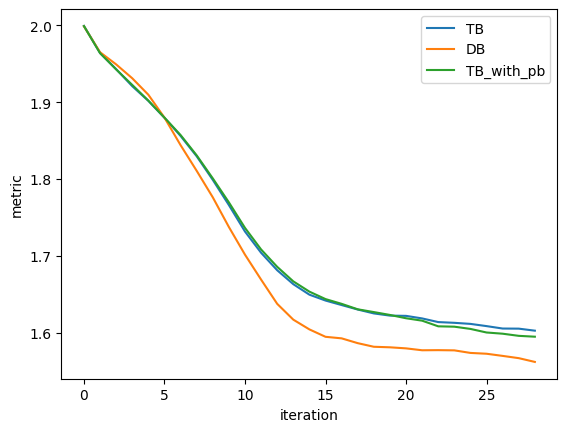

In [ ]:
visited_DB = []
visited_TB = []
visited_TBpb = []
trajectory_balance_mem = []
detailed_balance_mem = []
tbpb_balance_mem = []
plt.ion()

for i in range(op):
    optimizer_DB.zero_grad()
    x = loss_fn_DB()
    loss_DB = x[0]
    for j in x[1]:
        visited_DB.append(j)
    loss_DB.backward()
    optimizer_DB.step()
    ####
    optimizer_TB_Pfs.zero_grad()
    optimizer_TB_log_Z.zero_grad()
    x = loss_fn_TB()
    loss_TB = x[0]
    for j in x[1]:
        visited_TB.append(j)
    loss_TB.backward()
    optimizer_TB_Pfs.step()
    optimizer_TB_log_Z.step()
    ###
    optimizer_TBpb_Pfs.zero_grad()
    optimizer_TBpb_log_Z.zero_grad()
    x = loss_fn_TBpb()
    loss_TBpb = x[0]
    for j in x[1]:
        visited_TBpb.append(j)
    loss_TBpb.backward()
    optimizer_TBpb_Pfs.step()
    optimizer_TBpb_log_Z.step()
    if i % 100 == 0:
        visited_DB = visited_DB[-10000:]
        visited_TB = visited_TB[-10000:]
        visited_TBpb = visited_TBpb[-10000:]
        detailed_balance_mem.append(eloss(visited_DB, len(visited_DB)))
        trajectory_balance_mem.append(eloss(visited_TB, len(visited_TB)))
        tbpb_balance_mem.append(eloss(visited_TBpb, len(visited_TBpb)))
        clear_output(wait=True)
        plt.plot(trajectory_balance_mem)
        plt.plot(detailed_balance_mem)
        plt.plot(tbpb_balance_mem)
        plt.legend(['TB', 'DB', 'TB_with_pb'])
        plt.xlabel('iteration')
        plt.ylabel('metric')
        plt.draw()
        plt.pause(0.001)
        plt.clf()